In [56]:
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt


# Perform edge detection
def hough_transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale

    kernel = np.ones((15, 15), np.uint8)
    opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)  # Open (erode, then dilate)
    # cv2.imwrite('../pictures/output/opening.jpg', opening)

    edges = cv2.Canny(opening, 50, 100, apertureSize=3)  # Canny edge detection
    # cv2.imwrite('../pictures/output/canny.jpg', edges)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)  # Hough line detection
    hough_lines = []

    # Lines are represented by rho, theta; convert to endpoint notation
    for line in lines:
        for rho, theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            hough_lines.append(((x1, y1), (x2, y2)))

    # cv2.imwrite('../pictures/output/hough.jpg', img)
    return hough_lines


# Random sampling of lines
def sample_lines(lines, size):
    if size > len(lines):
        size = len(lines)
    return random.sample(lines, size)


def det(a, b):
    return a[0] * b[1] - a[1] * b[0]


# Find intersection point of two lines (not segments!)
def line_intersection(line1, line2):
    x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    div = det(x_diff, y_diff)
    if div == 0:
        return None  # Lines don't cross

    d = (det(*line1), det(*line2))
    x = det(d, x_diff) / div
    y = det(d, y_diff) / div

    return x, y


# Find intersections between multiple lines (not line segments!)
def find_intersections(lines, img):
    intersections = []
    for i in range(len(lines)):
        line1 = lines[i]
        for j in range(i + 1, len(lines)):
            line2 = lines[j]

            if not line1 == line2:
                intersection = line_intersection(line1, line2)
                if intersection:  # If lines cross, then add
                    # Don't include intersections that happen off-image
                    # Seems to cost more time than it saves
                    # if not (intersection[0] < 0 or intersection[0] > img.shape[1] or
                    #                 intersection[1] < 0 or intersection[1] > img.shape[0]):
                    # print 'adding', intersection[0],intersection[1],img.shape[1],img.shape[0]
                    intersections.append(intersection)

    return intersections


# Given intersections, find the grid where most intersections occur and treat as vanishing point
def find_vanishing_point(img, grid_size, intersections):
    # Image dimensions
    image_height = img.shape[0]
    image_width = img.shape[1]

    # Grid dimensions
    grid_rows = (image_height // grid_size) + 1
    grid_columns = (image_width // grid_size) + 1

    # Current cell with most intersection points
    max_intersections = 0
    best_cell = None

    for i in range(grid_rows):
        for j in range(grid_columns):
            cell_left = i * grid_size
            cell_right = (i + 1) * grid_size
            cell_bottom = j * grid_size
            cell_top = (j + 1) * grid_size
            cv2.rectangle(img, (cell_left, cell_bottom), (cell_right, cell_top), (0, 0, 255), 10)

            current_intersections = 0  # Number of intersections in the current cell
            for x, y in intersections:
                if cell_left < x < cell_right and cell_bottom < y < cell_top:
                    current_intersections += 1

            # Current cell has more intersections that previous cell (better)
            if current_intersections > max_intersections:
                max_intersections = current_intersections
                best_cell = ((cell_left + cell_right) / 2, (cell_bottom + cell_top) / 2)

    if best_cell != None:
        rx1 = int(best_cell[0] - grid_size / 2)
        ry1 = int(best_cell[1] - grid_size / 2)
        rx2 = int(best_cell[0] + grid_size / 2)
        ry2 = int(best_cell[1] + grid_size / 2)
        cv2.rectangle(img, (rx1, ry1), (rx2, ry2), (0, 255, 0), 10)
        # cv2.imwrite('../pictures/output/center.jpg', img)

    return best_cell


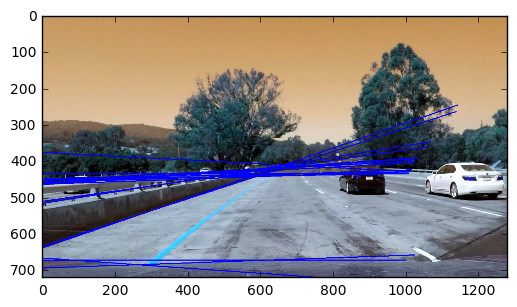

(600.0, 360.0)


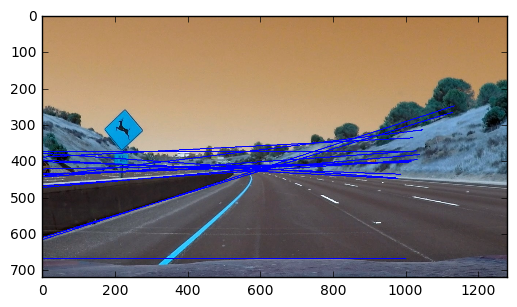

(600.0, 360.0)


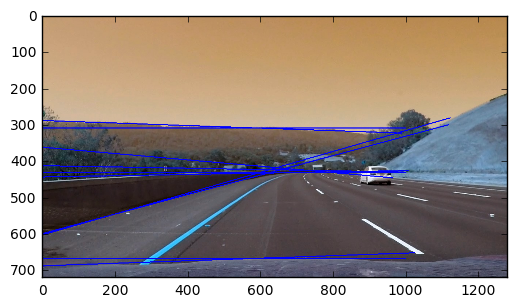

(600.0, 360.0)


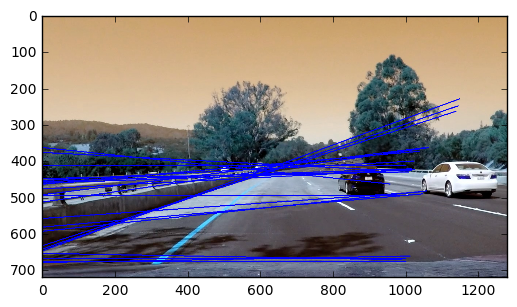

(600.0, 360.0)


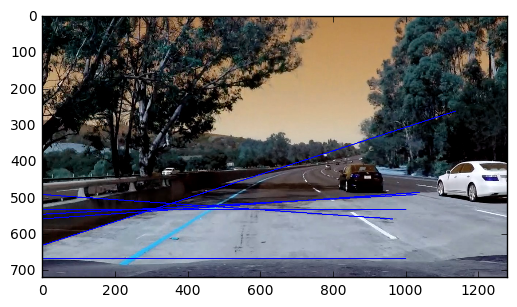

(360.0, 600.0)


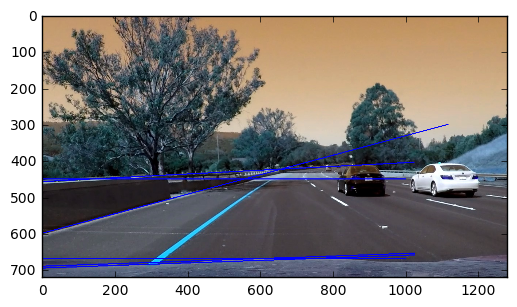

(600.0, 360.0)


In [57]:
import os
import glob

i = 0
images = glob.glob('./test_images/test*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    hough_lines = hough_transform(img)
    if hough_lines:
        random_sample = sample_lines(hough_lines, 100)
        intersections = find_intersections(random_sample, img)
        if intersections:
            grid_size = min(img.shape[0], img.shape[1]) // 3
            plt.imshow(img)
            plt.show()
            vanishing_point = find_vanishing_point(img, grid_size, intersections)
            print(vanishing_point)
            filename = './test_images/' + str(i) + '.jpg'

            cv2.imwrite(filename, img)